## 酒馆和客人的故事

In [1]:
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

%matplotlib inline

In [90]:
data = {
    'tra': pd.read_csv('./data/air_visit_data.csv'),
    'as': pd.read_csv('./data/air_store_info.csv'),
    'hs': pd.read_csv('./data/hpg_store_info.csv'),
    'ar': pd.read_csv('./data/air_reserve.csv'),
    'hr': pd.read_csv('./data/hpg_reserve.csv'),
    'id': pd.read_csv('./data/store_id_relation.csv'),
    'tes': pd.read_csv('./data/sample_submission.csv'),
    'hol': pd.read_csv('./data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

### 到店数据（训练数据）

In [5]:
data['tra'].dtypes

air_store_id    object
visit_date      object
visitors         int64
dtype: object

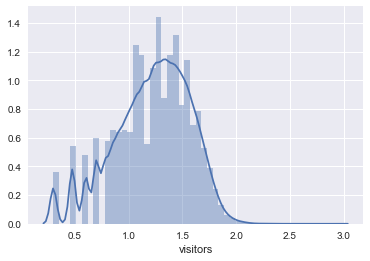

In [9]:
sns.distplot(np.log10(data['tra']['visitors']+1))

In [3]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])

visitors = data['tra'].groupby('visit_date')['visitors'].sum().to_frame(name='count')
visitors['month'] = visitors.index.month
visitors['dayofweek'] = visitors.index.dayofweek
# visitors['dayofweek'] = visitors['dayofweek'].map({0: 'Monday', 1: 'Tuesday',2: 'Wednesday', 3:'Thursday', 4: 'Friday', 5:'Saturday', 6: 'Sunday'})


In [118]:
plt.style.available

['seaborn-paper',
 'seaborn-talk',
 'seaborn-muted',
 'seaborn-whitegrid',
 'seaborn-dark-palette',
 'seaborn-dark',
 'seaborn-bright',
 '_classic_test',
 'seaborn-pastel',
 'fivethirtyeight',
 'seaborn-ticks',
 'ggplot',
 'dark_background',
 'grayscale',
 'classic',
 'seaborn-white',
 'seaborn-notebook',
 'bmh',
 'seaborn-poster',
 'seaborn',
 'seaborn-deep',
 'seaborn-darkgrid',
 'seaborn-colorblind']

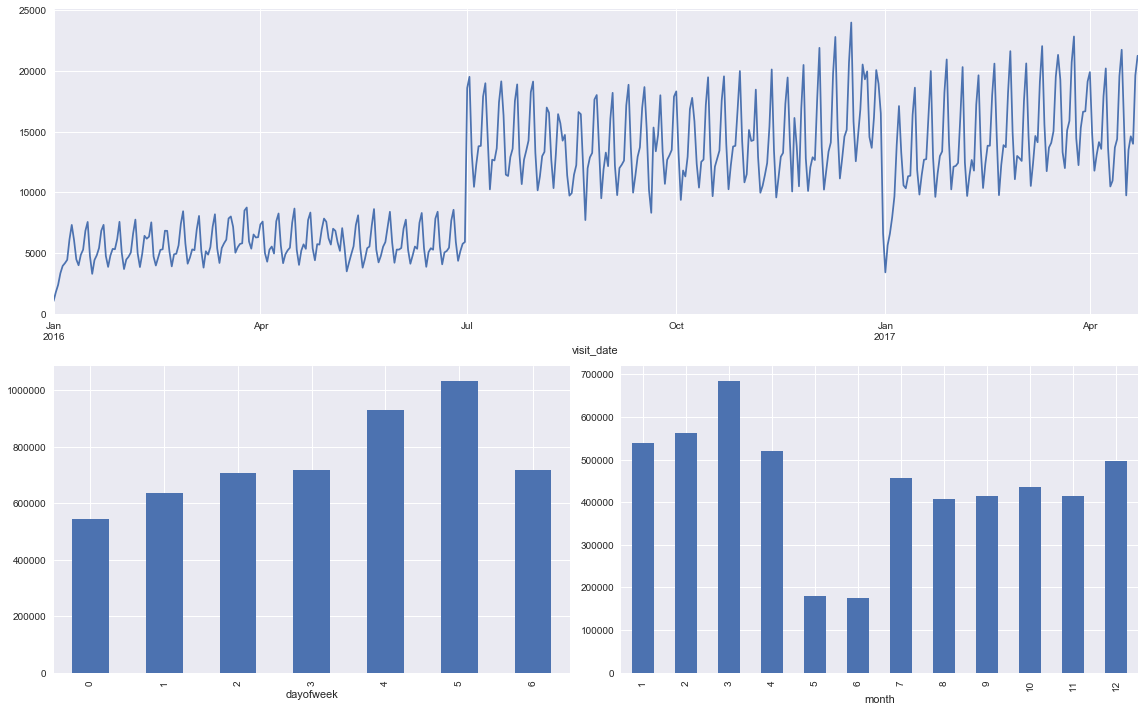

In [4]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(16, 10))
ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1 = plt.subplot2grid((2, 2), (1, 0))
ax2 = plt.subplot2grid((2, 2), (1, 1))

visitors['count'].plot(ax=ax0)
visitors.groupby('dayofweek')['count'].sum().plot.bar(ax=ax1)
visitors.groupby('month')['count'].sum().plot.bar(ax=ax2)

plt.tight_layout()

### 假期数据

In [5]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
# data['hol'].set_index('visit_date', inplace=True)
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [6]:
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [7]:
annos = data['hol'].groupby('holiday_flg')['holiday_flg'].count()
annos[0]

482

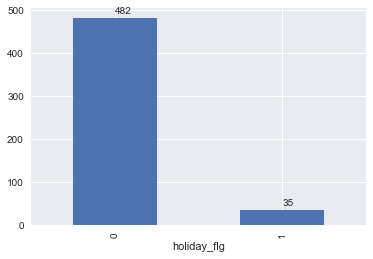

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
annos = data['hol'].groupby('holiday_flg')['holiday_flg'].count()
data['hol'].groupby('holiday_flg')['holiday_flg'].count().plot.bar()
for i in annos.index:
    ax.annotate(annos[i], xy=(i, annos[i]), xytext=(i, annos[i]+10))

In [193]:
data['hol'][data['hol']['holiday_flg']==1]

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
10,2016-01-11,Monday,1
41,2016-02-11,Thursday,1
79,2016-03-20,Sunday,1
80,2016-03-21,Monday,1
119,2016-04-29,Friday,1
123,2016-05-03,Tuesday,1
124,2016-05-04,Wednesday,1


### 预定信息

In [199]:
data['ar'].head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [200]:
data['hr'].head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [214]:
data['hr'].shape

(28183, 6)

### hpg和air的预定信息中的商家不一样！
所以下面的方法可能有问题...

In [36]:
# 增加source，表示预定信息来源
data['hr'] = data['hr'].merge(data['id'], on='hpg_store_id')
data['hr'].loc[:, 'src'] = 'h'
data['ar'].loc[:, 'src'] = 'a'

In [37]:
# 把hpg和air的预定信息合并为reserve，方便处理
cols = ['air_store_id', 'visit_datetime', 'reserve_datetime', 'reserve_visitors', 'src']
reserve = pd.concat([data['ar'], data['hr'][cols]])

for col in ['visit_datetime', 'reserve_datetime']:
    reserve[col] = pd.to_datetime(reserve[col])

In [13]:
reserve.tail()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,src
28178,air_84f6876ff7e83ae7,2017-04-01 21:00:00,2017-03-10 20:00:00,2,h
28179,air_84f6876ff7e83ae7,2017-04-02 17:00:00,2017-04-02 14:00:00,2,h
28180,air_84f6876ff7e83ae7,2017-04-08 19:00:00,2017-04-03 12:00:00,3,h
28181,air_84f6876ff7e83ae7,2017-04-08 20:00:00,2017-03-09 07:00:00,4,h
28182,air_84f6876ff7e83ae7,2017-04-28 18:00:00,2017-04-10 22:00:00,5,h


In [20]:
print('Total reserves: {}'.format(data['hr'].shape[0] + data['ar'].shape[0]))
print('Air ratio: {:5.3f}'.format( data['ar'].shape[0] / (data['hr'].shape[0] + data['ar'].shape[0])))
print('Hpg ratio: {:5.3f}'.format( data['hr'].shape[0] / (data['hr'].shape[0] + data['ar'].shape[0])))

Total reserves: 120561
Air ratio: 0.766
Hpg ratio: 0.234


In [45]:
# rv: 预定量    rv_visit: 当天预约会到店的人数
rv = reserve.groupby(reserve['reserve_datetime'].dt.date)['reserve_visitors'].sum()
rv.index = pd.to_datetime(rv.index)

rv_visit = reserve.groupby(reserve['visit_datetime'].dt.date)['reserve_visitors'].sum()
rv_visit.index = pd.to_datetime(rv_visit.index)

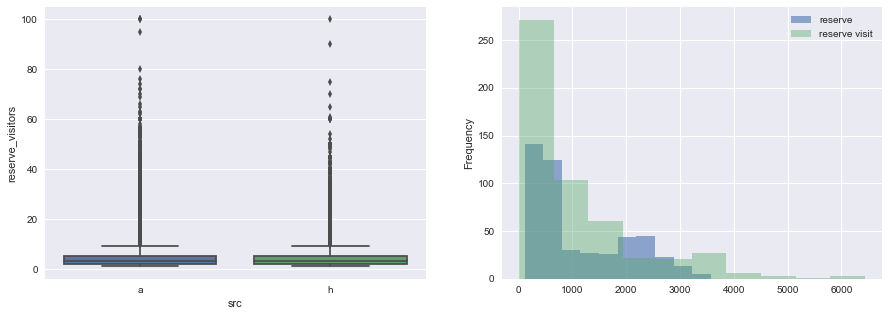

In [75]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))

# 不同来源的预定量
sns.boxplot(x='src', y='reserve_visitors', data=reserve, ax=ax0)

# 当天的预定量 vs 预约到店人数
rv.plot.hist(alpha=0.6, ax=ax1)
rv_visit.plot.hist(alpha=0.4, ax=ax1)
ax1.legend(['reserve', 'reserve visit'])

---
**实际到店人数 vs 预定人数**

---

In [55]:
rv_and_visit = pd.DataFrame({'visitors': visitors['count'], 'rv': rv, 'rv_visit': rv_visit})

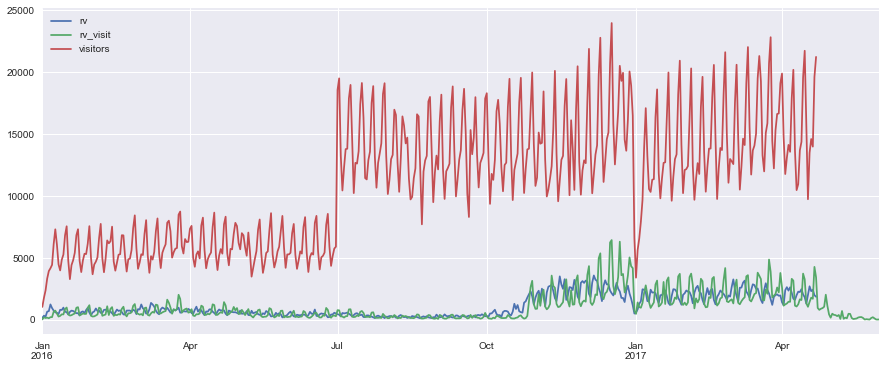

In [58]:
rv_and_visit.plot(figsize=(15, 6))

### 商家信息

In [76]:
data['as'].head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [77]:
data['hs'].head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [78]:
tmp = data['hs'].merge(data['id'], on='hpg_store_id', how='left')

In [87]:
data['hs'].shape

(4690, 5)

In [92]:
tmp.shape

(4690, 6)

In [91]:
data['hr']['hpg_store_id'].unique().shape

(13325,)